In [1]:
import numpy as np
import scipy as sp
import scipy.ndimage.filters as filters
from scipy.interpolate import interp1d as spline

from matplotlib import pyplot as plt
import MAPInference as mapinf

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Approximating Bayesian inference in a network model with Hebbian learning and winner take all dynamics

Recall from the main text and MAP_Estimation_Demo.ipynb that the population remapping appears to approximate *Maximum a Posteriori* ($MAP$) inference of the stimulus given the prior experience of the animal. 
(We also mentioned that in a model that included dynamics, a similar result would likely come from the population sampling from the posterior)



For the Rare Morph condition, that $MAP$ estimation looked like the following

C:\Users\mplitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'MAP Estimate')

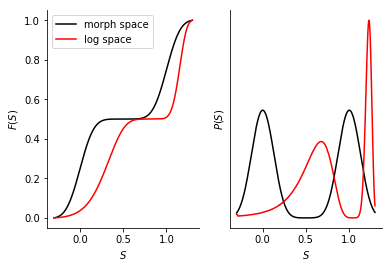

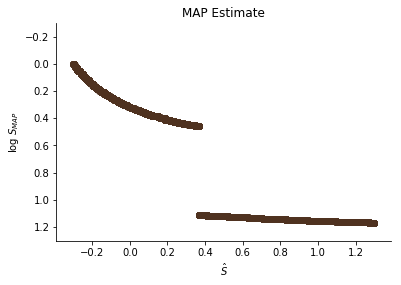

In [7]:
S_hat = np.linspace(-.3,1.3,num=1E4)
rare_prior,rare_log_prior,rare_sampling_spline,f = mapinf.rare_prior(plot=True) # plot prior
rare_map = mapinf.get_MAP(rare_log_prior,S_hat) # get MAP estimate
f,ax = plt.subplots()
ax.scatter(S_hat,rare_map,color=plt.cm.copper(.25))
ax.set_ylim([1.3,-.3])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("log $S_{MAP}$")
ax.set_xlabel("$\hat{S}$")
ax.set_title("MAP Estimate")


and for the Frequent Morph condition, MAP estimation looked like ... 

Text(0.5, 1.0, 'MAP Estimate')

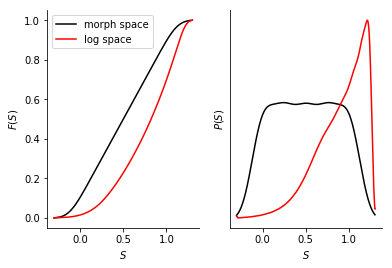

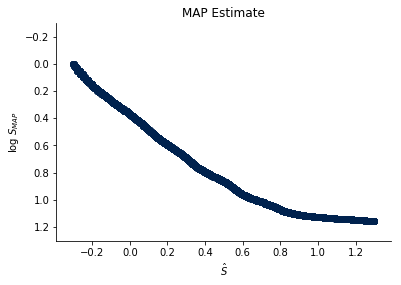

In [8]:
freq_prior, freq_log_prior,freq_sampling_spline,f = mapinf.freq_prior(plot=True)
freq_map = mapinf.get_MAP(freq_log_prior,S_hat)
f,ax = plt.subplots()
ax.set_ylim([1.3,-.3])
ax.scatter(S_hat,freq_map,color=plt.cm.cividis(0.))
ax.set_ylim([1.3,-.3])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("log $S_{MAP}$")
ax.set_xlabel("$\hat{S}$")
ax.set_title("MAP Estimate")

This result provides a simple yet powerful normative framework for making predictions about the extent the CA1 population will remap under different conditions. However, this framework does not give us much insight about the cellular and circuit level mechanisms underlying this phenomena. In the work below, we develop a toy model that is able to recapitulate this result using physiologically plausible learning rules with few bells and whistles. 

We do not attempt to make any rigorous theoretical arguments about this class of models and their ability to perform *MAP* inference.
For more a more rigorous analysis of winner-take-all systems that can perform optimal inference see the following papers:
- Nessler B, Pfeiffer, M, Maass W (2009) STDP enables spiking neurons to detect hidden causes of their inputs. *NIPS* https://papers.nips.cc/paper/3744-stdp-enables-spiking-neurons-to-detect-hidden-causes-of-their-inputs.pdf
- Habenschuss S, Puhr H, Maass W (2013) Emergence of optimal decoding of population codes through STDP. *Neural Computation* http://cognet.mit.edu/journal/10.1162/neco_a_00446
- Habenschuss S, Bill J, Nessler B (2012) Homeostatic plasticity in Bayesian spiking netowrks as Expectation Maximization with posterior constraints. *NIPS* https://papers.nips.cc/paper/4593-homeostatic-plasticity-in-bayesian-spiking-networks-as-expectation-maximization-with-posterior-constraints.pdf

### Motivation using single cell model
Consider a single cell that performs Hebbian learning on its inputs. If the input neurons, $x_i$ , are a basis for the stimulus and the weights are initialized randomly and small, after learning, the weights of the inputs, $w_i$ will reflect the statistics of the inputs. In particular they will approximate the prior distribution for the stimulus. In the following example, we take a single linear point neuron that itself receives input from a set of neurons whose firing rates are radial basis functions for some external stimulus. 

The output of the cell $y$ is just a weighted sum of its inputs: $y=\sum_i{w_i x_i} = \alpha w^{T}x$ where $\alpha$ is a constant

Weights are updated according a Hebbian learning rule with forgetting $\Delta w_i = \eta x_i y_i - \tau $ 

We will also add that weights cannot be negative or go beyond some max value $w_i := min \{ max \{w_i + \Delta w_i,0 \},w_{max}\}$

-$\eta$ is the learning rate

-$\tau$ is a forgetting rate

In [ ]:
### EXAMPLE SINGLE CELL HEBBIAN LEARNING

def single_cell_model(log_cumprior_spline,d):
    '''
    implement hebbian learning for a single cell with inputs that are RBFs for some stimulus
    inputs: log_cumprior_spline - numpy univariate spline for sampling from the cumulative prior
            d - dictionary of parameters
    returns: w - weights of learned model
            yy - activity of cell
    '''
    
    ### INITIALIZATIONS
    THETA = np.linspace(-.3,1.3,num=d['nInputs']) 
    if d['alpha'] is None:
        d['alpha']=1/d['nInputs']
        
        
    w = np.random.rand(d['nInputs']) # uniformly distributed random weights
    
    #working in log space
    samples = log_cumprior_spline(np.linspace(0,1,num=d['nSamples'])) # generate samples that tile the prior
    samples = np.random.permutation(samples) # randomly permute them
    samples = log_cumprior_spline(np.random.rand(d['nSamples']))
    
    ### LEARNING
    
    for i,s in enumerate(samples.tolist()):
        # generate samples from inputs
        x =gaussian(THETA,d['sigma'],s+d['stim noise']*np.random.randn(1)) + d['stim noise']*np.random.randn(THETA.shape[0])
#         x = 1.*((np.abs(THETA-s+d['stim noise']*np.random.randn(1)))<=d['sigma']) 
#         if s>.9:
#             print(s,x[-10:])
        y=np.maximum(d['alpha']*np.dot(w,x) + d['act noise']*np.random.randn(1),0) # rectified activation of cell
        
        dw = d['eta']*x*y - d['tau'] + d['dW noise']*np.random.randn(w.shape[0])
        w+=dw 
        w=np.maximum(np.minimum(w,d['Wmax']),0) # rectify and clamp range of weights
        

    ### SAMPLE FROM LEARNED MODEL
    morph_theta = np.linspace(-.1,1.1,num=1000) # morph values to sample at
    test_theta = morph_2_logstim(morph_theta) # convert morph_theta to log space
    
    yy = np.zeros(test_theta.shape) # output 
    for i,s in enumerate(test_theta.tolist()):
        # inputs
        x =gaussian(THETA,d['sigma'],s+d['stim noise']*np.random.randn(1)) + d['stim noise']*np.random.randn(THETA.shape[0])
        
        yy[i]=np.maximum(d['alpha']*np.dot(w,x) + d['act noise']*np.random.randn(1),0) # rectified activation of cell
    
    return w,yy,morph_theta,test_theta,samples


In [ ]:
d_singlecell = {'stim noise': .05, # constant for sampling from standard Gaussian noise
    'nInputs': 150, # number of input neurons
    'nSamples':1000, # num training samples
    'alpha':None,
    'eta': .15, # learning rate, results are somewhat sensitive to this value
    'sigma': .08, # width of radial basis functions
    'act noise':.05, # noise to apply to output
    'dW noise': 0.01, # constant to apply to weight update noise 
    'tau': .00, # forgetting rate
    'Wmax':10 }

# rare morph prior
w,y,morph_theta,test_theta,samples = single_cell_model(rare_lcs,d_singlecell)

f,ax = plt.subplots()

ax.plot(np.linspace(0,1,num=w.shape[0]),w,color='blue')
ax.set_ylabel('$\|w_i\|$')
ax.yaxis.label.set_color('blue')
ax.tick_params(axis='y', colors='blue')
ax_dense = ax.twinx()
ax_dense.plot((samp+.3)/1.6,rare_log_dens,color='black',label='Prior Density')
ax_dense.set_ylabel('$P(S)$')
ax_dense.set_yticks([])
ax.set_xlabel('Input neuron peak selectivity/morph value')
ax.set_title("Rare morph prior")
f.savefig(os.path.join(figdir,"singlecell_weights_rare.pdf" ))
# frequent morph prior
w,y,morph_theta,test_theta,samples = single_cell_model(fam_lcs,d_singlecell)

f,ax = plt.subplots()

ax.plot(np.linspace(0,1,num=w.shape[0]),w,color='blue')
ax.set_ylabel('$\|w_i\|$')
ax.yaxis.label.set_color('blue')
ax.tick_params(axis='y', colors='blue')
ax_dense = ax.twinx()
ax_dense.plot((samp+.3)/1.6,fam_log_dens,color='black',label='Prior Density')
ax_dense.set_ylabel('$P(S)$')
ax_dense.set_yticks([])
ax.set_xlabel('Input neuron peak selectivity/morph value')
ax.set_title("Frequent morph prior")

f.savefig(os.path.join(figdir,"singlecell_weights_freq.pdf" ))

Note that there are edge effects with radial basis functions.

This is pretty cool, but the resulting output of this cell is not actually particularly useful quantity for computing the posterior. (It would be something like $P(\hat{S})$ marginalized over all stimuli/the probability of ever guessing $\hat{S}$). If instead, we had neurons that could compute basis functions for the prior or compute the prior for a narrow support of the stimulus ($\vec{w} \approx \delta(x-\hat{S}) \ast P(S)$), then the population could be used to read out a probability distribution. 

One way to  get neurons to to do this would be to have cells compete to represent different aspects of the stimulus. One simple way to have cells compete is with Winner-Take-All dynamics. In this case, all of the computations for cell activation are the same, except that only $K$ neurons get to update their weights after any given stimulus presentation. The idea here is that these neurons reach threshold first and then inhibit their neighbors.

The assumption/interpretation of the results of such a model is that representations are activated proportional to the approximate posterior probability or that the stimulus is represented linearly in a high dimensional coding direction between the population centroid activation for one extreme of the stimulus and the population centroid activation for the other extreme of the stimulus. 


# K-WTA Network Model

Now consider a population of $N$ cells,$\vec{y}$, that performs Hebbian learning on its inputs. 

Inputs to the cells $ \vec{x} = \left( \begin{array}{c} x_1 \\ x_2 \\ \vdots \\ x_j \\ \vdots \\ x_M \end{array} \right) $ are neurons with radial basis function tuning for the stimulus
$x_j(S) = exp \left( \frac{(\mu_j -S)^{2}}{\sigma^{2}} \right) $

And the outputs of the cells $\vec{y} = \left( \begin{array}{c} y_1 \\ y_2 \\ \vdots \\ y_i \\ \vdots \\ y_N \end{array} \right) $ are rectified linear functions of their inputs 
$ y_i=  \alpha \tilde{w}_{i}^{T}\vec{x}  \Theta ( \tilde{w}_{i}^{T} \vec{x} - \kappa ( W\vec{x} ) ) $ where $\Theta (\cdot) $ is the Heviside step function, $\kappa (\cdot) $ is a variable threshold that sets the number of neurons that are greater than $0$ to $K$, and $W$ is the matrix of input weights where $w_{ij}$ is the weight from input neuron $x_j$ to neuron $y_i$. $\tilde{w}_{i}^{T}$ is the $i^{th}$ row of $W$, $\alpha$ is a constant as before


Weights are updated according the same Hebbian learning rule but only the $K$ neurons with the highest activation are allowed to update on each iteration $\Delta w_{ij} = \eta x_j y_i \Theta ( \tilde{w}_{i}^{T} \vec{x} - \kappa ( \tilde{w}_{i}^{T}\vec{x} ) ) - \tau $ . $\eta$ and $\tau$ are again constants

We maintain from the single cell model that weights cannot be negative or go beyond some max value $w_{ij} := min \{ max \{w_{ij} + \Delta w_{ij},0 \},w_{max}\}$

We will also allow for additive zero-centered Gaussian noise at each step of the calculation. 


### Training stage pseudocode:

- Randomly initialize $W$


Repeat: {
- Draw $S$ according to prior
- calculate $\vec{x}(S)$, allow for additive Gaussian noise to $S$
- using current $W$, determine $K$ winners 
- calculate $\vec{y}$, allow for additive Gaussian noise
- update weights for $K$ winners, decay weights for all, allow for additive Gaussian noise

}

In [ ]:
def plot_simmat(S_tm,em,vmax=None,morphcm='cool'):
    '''plot similarity matrices comparing each trial'''

    if vmax is None:
        # vmax=.3
        vmax = np.percentile(S_tm.ravel(),90)
        # vmin=.0
        vmin = np.percentile(S_tm.ravel(),10)


    f = plt.figure(figsize=[5,5])
    gs = gridspec.GridSpec(14,14)

    

    # sort by morph value
    cm_ax = f.add_subplot(gs[:10,:])
    cm_ax.imshow(S_tm,cmap='Greys',vmin=vmin,vmax=vmax,aspect='auto')
    cm_ax.set_yticks([])
    cm_ax.set_xticks([])

    mm_ax = f.add_subplot(gs[10:12,:])
    mm_ax.scatter(np.arange(0,em.shape[0]),em,c=1-em,cmap=morphcm)
    mm_ax.set_xlim([0,em.shape[0]])
 

    return f, [cm_ax,mm_ax]

In [ ]:

# model parameters
d_def= {'stim noise': .05, # constant for sampling from standard Gaussian noise
    'nInputs': 100, # number of input neurons
    'nSamples': 1000, # number of training samples
    'alpha':None, # if None, set to 1/nInputs
    'eta': .15, # learning rate, results are somewhat sensitive to this value
    'sigma': .15, # width of radial basis functions
    'act noise':2., # noise to apply to output
    'dW noise': .1, # constant to apply to weight update noise 
    'tau': .005, # forgetting rate
    'n_neurons':100, # number of output neurons
    'wta_k': .4,# proportion of population that are "winners"
    'Wmax': 10
    }

sat_exp = lambda x : x#10.*(1-np.exp(-.3*x))
def kwta_network_model(log_cumprior_spline, d):
    
    ## INITIALIZATIONS
    THETA = np.linspace(-.3,1.3,num=d['nInputs']) 
    if d['alpha'] is None:
        d['alpha']=1/d['nInputs']
    W = .1*np.random.rand(d['nInputs'],d['n_neurons'])
    k = int(d['n_neurons']*d['wta_k'])
    
    
    #draw samples for learning
#     samples = log_cumprior_spline(np.linspace(0,1,num=d['nSamples']))
#     samples = np.random.permutation(samples)
    samples = log_cumprior_spline(np.random.rand(d['nSamples']))
    
    
    ## LEARNING
    
    for i,s in enumerate(samples.tolist()):
        # inputs
        x =gaussian(THETA,d['sigma'],s+d['stim noise']*np.random.randn(1)) + d['stim noise']*np.random.randn(THETA.shape[0])
        # activation of each cell
        act = np.matmul(W.T,x)
        sort = np.argsort(act) # sort to find K winners
        # determine output for K winners
        Y = np.zeros(act.shape)
        Y[sort[-1:-k-1:-1]]=sat_exp(d['alpha']*act[sort[-1:-k-1:-1]] + d['act noise']*np.random.randn(k))
#         Y[sort[-k:0:-1]]=sat_exp( d['act noise']*np.random.randn(100-k))
        Y = np.maximum(Y,0) # make sure noise doesn't push the value negative
        # update weights
        dw = d['eta']*x[:,np.newaxis]*Y[np.newaxis,:] + d['dW noise']*np.random.randn(W.shape[0],W.shape[1])- d['tau']
        W+=dw
        W=np.maximum(np.minimum(W,d['Wmax']),0)
       

    
    ## SAMPLING
    morph_theta = np.linspace(-.2,1.2,num=1000)
    test_theta = morph_2_logstim(morph_theta)
    YY = np.zeros([test_theta.shape[0],d['n_neurons']])
    for i,s in enumerate(test_theta.tolist()):
        # inputs
        x =gaussian(THETA,d['sigma'],s+d['stim noise']*np.random.randn(1)) + d['stim noise']*np.random.randn(THETA.shape[0])
        # activation of each cell
        act = np.matmul(W.T,x)
        sort = np.argsort(act) # sort to find K winners
        # determine output for K winners
        YY[i,sort[-1:-k-1:-1]]=sat_exp(d['alpha']*act[sort[-1:-k-1:-1]] + d['act noise']*np.random.randn(k))
        YY[i,sort[-k:0:-1]]=sat_exp( .01*np.random.randn(100-k))
        YY[i,:] = np.maximum(YY[i,:],0)
#         print(np.max(YY))

    ## LOG SIMILARITY RATIO
    centroid0, centroid1 = YY[morph_theta<.05,:].mean(axis=0),YY[morph_theta>.9,:].mean(axis=0)
    centroid0/=np.linalg.norm(centroid0.ravel(),ord=2)
    centroid1/=np.linalg.norm(centroid1.ravel(),ord=2)
    YY=YY/np.linalg.norm(YY,ord=2,axis=1)[:,np.newaxis]
#     print(centroid0.shape,centroid1.shape,YY.shape)
#     lsr = np.log(np.matmul(YY,centroid0[:,np.newaxis])+ 1E-5)-np.log(np.matmul(YY,centroid1[:,np.newaxis])+ 1E-5)
    
    lsr = np.matmul(YY,centroid0[:,np.newaxis])/(np.matmul(YY,centroid0[:,np.newaxis])+np.matmul(YY,centroid1[:,np.newaxis]))
    
    return W,YY,lsr


# K-WTA Model for Rare Morph condition

plotting some example runs of the model

In [ ]:
SS_rare,LAR_rare = [],[]
THETA = np.linspace(-.3,1.3,num=d_def['nInputs']) 
for i in range(50):
    
    
    if i%10==0:
        print(i)
    W_rare,YY_rare,lar_rare= kwta_network_model(rare_lcs,d_def)
   
    # calculate similarity matrix
    YY_ = YY_rare/np.linalg.norm(YY_rare,2,axis=1)[:,np.newaxis]
    S = np.matmul(YY_,YY_.T)

    # save each models result
    SS_rare.append(S)
    LAR_rare.append(lar_rare)
    
    if i <6:
        f,ax = plt.subplots()
        trsh=ax.plot(logstim_2_morph(THETA),W_rare)
        ax.set_title('Single neuron weights')

        
#         f,ax = plt.subplots()
#         ax.imshow(S,cmap='Greys',vmin=np.percentile(S.ravel(),10),vmax=np.percentile(S.ravel(),90))
#         ax.set_title('Single Trial Similarity matrices')
        f, (s_ax,m_ax) = plot_simmat(S,np.linspace(0,1,num=1000),vmax=None,morphcm='cool')
        f.savefig(os.path.join(figdir,"rare_simmat_%i.pdf" % i))

        f,ax = plt.subplots()
        ax.scatter(np.linspace(-.1,1.1,num=1000),lar_rare)
        ax.set_title('Log Similarity Ratio')

        f,ax = plt.subplots()
        ax.set_title('Neuron weights')
        ax.set_xlabel('Input index')
        ax.set_ylabel('Output index')
        weight_sort = np.argsort(np.argmax(W_rare,axis=0))
        ax.imshow(W_rare[:,weight_sort].T,aspect='auto',cmap='magma')
        f.savefig(os.path.join(figdir,"rare_W_%i.pdf" % i))
        
        f,ax = plt.subplots()
        nrn_sort = np.argsort(np.argmax(YY_,axis=0))
        ax.imshow(YY_[:,nrn_sort],aspect='auto',cmap='magma')
        

# K-WTA Model for Frequent Morph condition

plotting some example runs of the model

In [ ]:
SS_fam,LAR_fam=[],[]
for i in range(50):
    if i%10==0:
        print(i)
    W_fam,YY_fam,lar_fam= kwta_network_model(fam_lcs,d_def)
    
    # trial x trial similarity
    YY_ = YY_fam/np.linalg.norm(YY_fam+1E-5,2,axis=1)[:,np.newaxis]
    S = np.matmul(YY_,YY_.T)

    # save single run results
    SS_fam.append(S)
    LAR_fam.append(lar_fam)


    if i<6:
        f,ax = plt.subplots()
        trsh=ax.plot(logstim_2_morph(THETA),W_fam)
        ax.set_title('Single neuron weights')
       #         f,ax = plt.subplots()
#         ax.imshow(S,cmap='Greys',vmin=np.percentile(S.ravel(),10),vmax=np.percentile(S.ravel(),90))
#         ax.set_title('Single Trial Similarity matrices')
        f, (s_ax,m_ax) = plot_simmat(S,np.linspace(0,1,num=1000),vmax=None,morphcm='cool')
        f.savefig(os.path.join(figdir,"fam_simmat_%i.pdf" % i))



        f,ax = plt.subplots()
        ax.scatter(np.linspace(-.1,1.1,num=1000),lar_fam)
        ax.set_title('Log Similarity Ratio')

        f,ax = plt.subplots()
        weight_sort = np.argsort(np.argmax(W_fam,axis=0))
        ax.imshow(W_fam[:,weight_sort].T,aspect = 'auto',cmap='magma')
        ax.set_title('Neuron weights')
        ax.set_xlabel('Input index')
        ax.set_ylabel('Output index')
        f.savefig(os.path.join(figdir,"fam_W_%i.pdf" % i))

          
        f,ax = plt.subplots()
        nrn_sort = np.argsort(np.argmax(YY_,axis=0))
        ax.imshow(YY_[:,nrn_sort],aspect='auto',cmap='magma')

## Compute difference between similarity matrices for different conditions

In [2]:
SS_rare_mu = np.array(SS_rare).mean(axis=0)
SS_fam_mu = np.array(SS_fam).mean(axis=0)
SS_dif = SS_rare_mu-SS_fam_mu
f,ax = plt.subplots()
im = ax.imshow(SS_dif,vmin=-.2,vmax=.2,cmap='seismic')
ax.set_title('Difference in trial x trial similarity (frequent-rare)')
f.colorbar(im)
f.savefig(os.path.join(figdir,'Sdiff.pdf'))

NameError: name 'np' is not defined

## marginal histogram for log-similarity ratio

In [ ]:
# calculate histograms for log-similarity ratios
bins = np.linspace(0.1,.9)
hist_rare,edges_rare = np.histogram(np.array(LAR_rare).ravel(),bins=bins)
print(hist_rare.shape)
hist_rare =hist_rare/hist_rare.sum()
f,ax = plt.subplots()
ax.fill_between(bins[1:],hist_rare,color=plt.cm.copper(.25),label='Rare',alpha=.3)


hist_fam,edges_fam = np.histogram(np.array(LAR_fam).ravel(),bins=bins)
hist_fam = hist_fam/hist_fam.sum()
ax.fill_between(bins[1:],hist_fam,color=plt.cm.cividis(0.),alpha=.3,label='Frequent')
ax.set_xlabel('S')
ax.set_ylabel('Prob')
ax.legend()
f.savefig(os.path.join(figdir,'SF_hist.pdf'))

## Comparing simulations and theory

The above LSR histogram from the simulations and the data remind us a little bit of the plots of the $MAP$ estimate as a function of the stimulus. To make the comparison a bit more clear lets look at the $MAP$ estimate as a function of the stimulus vs the log similarity ratio. We will allow for shift and scaling of the $MAP$ estimate to match the 

In [ ]:
LAR_rare_mu,LAR_fam_mu = np.median(np.array(LAR_rare),axis=0), np.median(np.array(LAR_fam),axis=0)
x = np.linspace(-.3,1.3,num=1000)
f,ax = plt.subplots(3,2,figsize=[5,12])
f.subplots_adjust(hspace=.5)

print(np.array(LAR_fam).shape)


ax[0,1].scatter(x,LAR_fam_mu,color=plt.cm.cividis(0.),alpha=.3)
ax[0,0].scatter(x,LAR_rare_mu,color=plt.cm.copper(1.),alpha=.3)
ax[0,0].set_ylabel('LSR')
ax[0,0].set_xlabel('morph')
ax[0,0].set_title('LSR - simulation')

ax[1,0].scatter(logstim_2_morph(theta),rare_p_shat,color=plt.cm.copper(1.),alpha=.3)
ax[1,1].scatter(logstim_2_morph(theta),fam_p_shat,color=plt.cm.cividis(0.),alpha=.3)
ax[1,0].set_ylim([1.1,-.1])
ax[1,1].set_ylim([1.1,-.1])
ax[1,0].set_ylabel('MAP estimate')
ax[1,0].set_xlabel('morph')
ax[1,0].set_title('MAP estimate from Bayes')


##
rare_map_spline = spline(logstim_2_morph(theta),rare_p_shat)
fam_map_spline = spline(logstim_2_morph(theta),fam_p_shat)

xx = x[np.newaxis,:]*np.ones([i+1,1])

rare_reg = hreg(epsilon=1.01) #linreg()
rare_reg.fit(rare_map_spline(xx.reshape([-1,1])),np.array(LAR_rare).reshape([-1,1]))
ax[2,0].scatter(x,LAR_rare_mu,color=plt.cm.copper(1.),alpha=.3)
ax[2,0].scatter(logstim_2_morph(theta),rare_reg.coef_*rare_p_shat + rare_reg.intercept_,color='orange')


fam_reg = hreg(epsilon = 1.01) #linreg()
fam_reg.fit(fam_map_spline(xx.reshape([-1,1])),np.array(LAR_fam).reshape([-1,1]))
ax[2,1].scatter(x,LAR_fam_mu,color=plt.cm.cividis(0.),alpha=.3)
ax[2,1].scatter(logstim_2_morph(theta),fam_reg.coef_*fam_p_shat + fam_reg.intercept_,color='blue')

In [ ]:
import matplotlib.gridspec as gridspec

In [ ]:
def plot_LAR(LAR,x,cmap='copper',ymin=-1.2,ymax=1.2):
    cmap = plt.cm.get_cmap(cmap)
    f = plt.figure()
    gs = gridspec.GridSpec(1,5)
    ax_scat = f.add_subplot(gs[:,:4])
    ax_hist = f.add_subplot(gs[:,-1])
    N = len(LAR)
    bins = np.linspace(ymin,ymax)
    print(N)
    for i,lar in enumerate(LAR):
        z = x.ravel().shape[0]
        inds = np.random.permutation(z)
        inds = inds[:int(.1*z)]
        ax_scat.scatter(x[inds],lar.ravel()[inds],color=cmap(np.float(i/N)),alpha=.4,s=8)
        hist,edges = np.histogram(lar.ravel(),bins=bins)
        ax_hist.fill_betweenx(edges[1:],hist/hist.sum(),color=cmap(np.float(i/N)),alpha=.4)
    ax_hist.set_ylim([ymin,ymax])
    ax_scat.set_ylim([ymin,ymax])
    ax_hist.set_yticks([])
    return f,(ax_scat,ax_hist)

In [ ]:
f,ax = plot_LAR(LAR_fam,(x+.3)/1.6,cmap='cividis',ymin=.2,ymax=.8)
ax[0].scatter((logstim_2_morph(theta)+.3)/1.6,fam_reg.coef_*fam_p_shat + fam_reg.intercept_,color=plt.cm.cividis(0.))
f.savefig(os.path.join(figdir,'fam_sf_map_reg.pdf'))

In [ ]:
f,ax = plot_LAR(LAR_rare,(x+.3)/1.6,cmap='copper',ymin=0.,ymax=1.)
ax[0].scatter((logstim_2_morph(theta)+.3)/1.6,rare_reg.coef_*rare_p_shat + rare_reg.intercept_,color=plt.cm.copper(.25))
f.savefig(os.path.join(figdir,'rare_sf_map_reg.pdf'))